In [1]:
from datetime import datetime
import os
PATH = os.getcwd()
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set()
import networkx
from networkx import *
import sys
from pathlib import Path
p = (Path('.')).resolve()
if str(p) not in sys.path:
    sys.path.insert(0,str(p))

In [2]:
from seirsplus.models import *
from seirsplus.networks import *
from seirsplus.sim_loops import *
from seirsplus.utilities import *
from seirsplus.parallel_run import *

## Parameter setup

### Social network

In [3]:
def get_network(N, p = 0.2):
    return {
    "G": Defer(gaussian_random_partition_graph,N, 20, 5, 0.5, 5/(N-20), directed=False),
    "N": N,
    "isolation groups": None,
    "p": p
    }

In [4]:
def random_graph(N,d, p =0.2):
    return {
        "G": Defer(fast_gnp_random_graph,N,d/N),
        "N": N,
        "p": p,
        "isolation groups": None
    }
        

In [5]:
def barabasi_albert(N,m):
    return {
        "G": Defer(barabasi_albert_graph,N,m),
        "N": N,
        "m": m,
        "isolation groups": None
    }

### Infection parameters

In [6]:
def infect_params(N,R0_mean, R0_coeffvar= None, average_introductions_per_day = 0, single_intro_by =None,):
    latentPeriod_mean, latentPeriod_coeffvar = 3.0, 0.6
    SIGMA   = 1 / gamma_dist(latentPeriod_mean, latentPeriod_coeffvar, N)
    presymptomaticPeriod_mean, presymptomaticPeriod_coeffvar = 2.2, 0.5
    LAMDA   = 1 / gamma_dist(presymptomaticPeriod_mean, presymptomaticPeriod_coeffvar, N)
    symptomaticPeriod_mean, symptomaticPeriod_coeffvar = 4.0, 0.4
    GAMMA   = 1 / gamma_dist(symptomaticPeriod_mean, symptomaticPeriod_coeffvar, N)
    infectiousPeriod = 1/LAMDA + 1/GAMMA
    onsetToHospitalizationPeriod_mean, onsetToHospitalizationPeriod_coeffvar = 11.0, 0.45
    ETA     = 1 / gamma_dist(onsetToHospitalizationPeriod_mean, onsetToHospitalizationPeriod_coeffvar, N)
    hospitalizationToDischargePeriod_mean, hospitalizationToDischargePeriod_coeffvar = 11.0, 0.45
    GAMMA_H = 1 / gamma_dist(hospitalizationToDischargePeriod_mean, hospitalizationToDischargePeriod_coeffvar, N)
    hospitalizationToDeathPeriod_mean, hospitalizationToDeathPeriod_coeffvar = 7.0, 0.45
    MU_H    = 1 / gamma_dist(hospitalizationToDeathPeriod_mean, hospitalizationToDeathPeriod_coeffvar, N)
    PCT_FATALITY = 0.08
    PCT_HOSPITALIZED = 0.035
    P_GLOBALINTXN = 0.4
    if R0_coeffvar is None:
        R0_coeffvar = R0_mean/10
    R0 = gamma_dist(R0_mean, R0_coeffvar, N)
    BETA = 1/infectiousPeriod * R0
    return dict(beta=BETA, sigma=SIGMA, lamda=LAMDA, 
                   gamma=GAMMA, 
                   gamma_asym=GAMMA, eta=ETA, gamma_H=GAMMA_H, mu_H=MU_H, 
                a=PCT_ASYMPTOMATIC, h=PCT_HOSPITALIZED, f=PCT_FATALITY,              
                    isolation_time=14, 
               average_introductions_per_day = average_introductions_per_day,
               introduction_days = [] if single_intro_by is None else Defer(single_introduction,single_intro_by)) 

In [7]:
def infect_params_orig(N,R0, average_introductions_per_day = 0, single_intro_by =None, skip_pre= False, pct_symptomatic= 0, pre_symptomatic_period=3, infectious_period = 6.5, incubation_period = 5.2):
    ETA = 0
    MU_H    = 0 
    PCT_FATALITY = 0
    PCT_HOSPITALIZED = 0
    PCT_ASYMPTOMATIC = 1-pct_symptomatic
    BETA = R0/infectious_period
    if skip_pre:
        lamda = 0
        gamma = 1/infectious_period
    else:
        gamma = 1/pre_symptomatic_period
        lamda = 1/(infectious_period-pre_symptomatic_period)
    if not (single_intro_by is None):
        print("***",single_intro_by)
        introduction_days = Defer(single_introduction,single_intro_by)
    else: 
        introduction_days = []
    return dict(skip_pre=skip_pre,beta=BETA, sigma=1/incubation_period, lamda= lamda, 
                   gamma=gamma, 
                   gamma_asym=gamma, eta=ETA, gamma_H=gamma, mu_H=MU_H, 
                a=PCT_ASYMPTOMATIC, h=PCT_HOSPITALIZED, f=PCT_FATALITY,              
                    isolation_time=14, 
               average_introductions_per_day = average_introductions_per_day,
               introduction_days = introduction_days ) 

### Testing and intervention parameters

In [8]:
def run_params(N,frac_tested,frequency, testing_compliance_symptomatic=0):
    MAX_TIME = 105
    D=  dict(T = MAX_TIME,
    runTillEnd = False,
    intervention_start_pct_infected = 0/100,
    initI = 0, # initial number of infected people
    #testing_cadence                 = testing_cadence,      # how often to do testing (other than self-reporting symptomatics who can get tested any day)
    #cadence_testing_days = cadence_testing_days, # dictionary mapping testing_cadence to schedule (None =  default weekly/workday/etc..)
    pct_tested_per_day              = frac_tested,           # max daily test allotment defined as fraction of population size
    test_falseneg_rate              = 0.25,    # test false negative rate, will use fn rate that varies with disease time
    max_pct_tests_for_symptomatics  = 1,           # max percent of daily test allotment to use on self-reporting symptomatics
    max_pct_tests_for_traces        = 1,           # max percent of daily test allotment to use on contact traces
    random_testing_degree_bias      = 0,             # magnitude of degree bias in random selections for testing, none here

    pct_contacts_to_trace           = 0.0,           # percentage of primary cases' contacts that are traced
    tracing_lag                     = 2,             # number of cadence testing days between primary tests and tracing tests

    isolation_lag_symptomatic       = 1,             # number of days between onset of symptoms and self-isolation of symptomatics
    isolation_lag_positive          = 1,             # test turn-around time (tat): number of days between administration of test and isolation of positive cases
    isolation_lag_contact           = 0,             # number of days between a contact being traced and that contact self-isolating


    testing_compliance_symptomatic                  = testing_compliance_symptomatic,    
    testing_compliance_traced                       = 0,
    testing_compliance_random                       = 1,  # assume employee testing is mandatory, so 100% compliance

    tracing_compliance                              = 0.0,

    isolation_compliance_symptomatic_individual     = 0.0,
    isolation_compliance_symptomatic_groupmate      = 0.0,
    isolation_compliance_positive_individual        = 0.0,
    isolation_compliance_positive_groupmate         = 0.0,  # isolate teams with a positive member, but suppose 20% of employees are essential workforce
    isolation_compliance_positive_contact           = 0.0,
    isolation_compliance_positive_contactgroupmate  = 0.0,
    test_priority = 'last_tested',
    stopping_policy = Defer(stop_at_detection,lag=1), 
    budget_policy = scale_to_pool # fraction of tests is determined as fraction of eligible pool
    )
    if isinstance(frequency,str):
        D["testing_cadence"] = frequency
    else:
        D[("testing_cadence","cadence_testing_days","cadence_cycle_length")] = Defer(test_frequency,frequency)
    return D
    



## Set up experiment

In [36]:
# random partition

totals = [1,2,7,14,28,35,42]

Rs = [1.2, 1.6, 2, 2.4, 2.8,3.2,3.6,4.0,4.4,4.8]
torun = []
SKIP_PRE = True

INIT_INFECT = 1
INTRO_DAY = 0

# heat map budget

network = barabasi_albert(N=500, m=9)
for total in totals:
    for f in [1,total]: 
        for R in Rs: #numpy.linspace(1.0,4.0,15):
            N = network['N']
            D = {"N":N,
                 "frequency":f,
                 "experiment" : "varying_total",
                 "type": f"freq={f}/tot={total}/R={R}",
                 "R":R,
                 "total": total,
                 **network, 
                 **infect_params_orig(N,R,average_introductions_per_day = INTRO_DAY, single_intro_by=None, skip_pre=SKIP_PRE),
                 **run_params(N,frac_tested=f/total,frequency=f, testing_compliance_symptomatic=0),
                 "initE": INIT_INFECT,
                 "runTillEnd": INIT_INFECT>0,
                }
            torun.append(D)


# external infection

for total in [28]:
    for rate in [1/14,1/10,1/7,1/3.5,1/2]:
        for f in [1,7,28]:# [1]+totals:
            if total % f: continue
            for R in Rs: #numpy.linspace(1.0,4.0,15):
                N = network['N']
                D = {"N":N,
                     "frequency":f,
                     "experiment" : "external_introductions",
                     "type": f"freq={f}/tot={total}/R={R}/ext={rate}",
                     "R":R,
                     "total": total,
                     **network, 
                     **infect_params_orig(N,R,average_introductions_per_day = rate, single_intro_by=None, skip_pre=SKIP_PRE),
                     **run_params(N,frac_tested=f/total,frequency=f, testing_compliance_symptomatic=0),
                     "initI_asym": 0,
                     "runTillEnd": True
                    }
                torun.append(D)

realizations = 100

In [37]:
len(torun)*realizations

29000

## Run several experiments in parallel

In [38]:
os.chdir(PATH)
print(os.getcwd())
if not os.path.exists("data/"):
    os.makedirs("data")

timestamp = datetime.now().strftime('%Y%m%d_%H_%M_%S')
#datadir = f"data/heatmap_{timestamp}_{realizations}"
datadir = f"data/barabasi_albert"
if not os.path.exists("data/barabasi_albert"):
    os.makedirs("data/barabasi_albert")

torun_fname = datadir+"/torun.pickle"
save_to_file(torun,torun_fname)

/Users/antares/Desktop/seirsplus


In [35]:
print(datadir)
print(PATH)
#os.chdir("seirsplus")
print(torun_fname)
os.getcwd()

data/barabasi_albert
/Users/antares/Desktop/seirsplus
data/barabasi_albert/torun.pickle


'/Users/antares/Desktop/seirsplus'

In [39]:
%%time
os.chdir("seirsplus")
!python3 -m seirsplus.parallel_run --torun "/Users/antares/Desktop/seirsplus/$torun_fname" --realizations $realizations --savename "../$datadir/heatmap_data"
os.chdir(PATH)

Arguments:
torun : /Users/antares/Desktop/seirsplus/data/barabasi_albert/torun.pickle
realizations : 100
savename : ../data/barabasi_albert/heatmap_data
Loading torun
Loaded
Preparing list to run
Starting execution of 29000 runs
100%|███████████████████████████████████| 29000/29000 [4:30:08<00:00,  1.79it/s]
done
Saving csv
Saving split parts
Saving pickle 1
Done
CPU times: user 5min 51s, sys: 1min 59s, total: 7min 51s
Wall time: 4h 30min 24s


In [40]:
os.chdir(PATH)
os.getcwd()

'/Users/antares/Desktop/seirsplus'

In [15]:
os.chdir(PATH)
data = read_from_file(datadir+"/heatmap_data")

Loading chunk 1


In [42]:
len(data)

29000

In [45]:
data.experiment.unique()

array(['varying_total', 'external_introductions'], dtype=object)

In [34]:
def censor(df):
    return df[df['numPositive/sum']>0]

def restrict(df,total,R):
    return df[(df.total==total) & (df.R==R)]

def summarize(df, percentile=0.9):
    print(f"Total: {df.total.unique()} R: {df.R.unique()} min(numPositive/sum): {df['numPositive/sum'].min()}")
    print(f"Frequency: risk(mean),risk({percentile*100:.0f}%) | overall(mean),overall({percentile*100:.0f}%)")
    for i in sorted(df.frequency.unique()):
        s = df[df.frequency==i]
        t=s['numInfectious/average']
        u = s['overallInfected/last']
        print(f"{i:02d}:        {t.mean():.2f}, {t.quantile(percentile):.2f}           "+
               f"| {u.mean():.2f} , {u.quantile(percentile):.1f}                   "+
               f"| count={t.count()} ")
summarize(censor(restrict(data,total=28,R=2.0)))

Total: [28] R: [2.] min(numPositive/sum): 1.0
Frequency: risk(mean),risk(90%) | overall(mean),overall(90%)
01:        1.54, 3.07           | 13.84 , 30.0                   | count=551 
07:        1.46, 2.93           | 13.55 , 29.7                   | count=494 
28:        1.91, 4.27           | 17.74 , 45.4                   | count=547 


In [35]:
def summary(df,fields = ['numInfectious/average','overallInfected/last','time/last'], p=0.9):
    def top(x): return x.quantile(p) 
    print(f"Total: {df.total.unique()} R: {df.R.unique()} min(numPositive/sum): {df['numPositive/sum'].min()}")
    D =  {f: ['mean',top] for f in fields}
    D[fields[0]].insert(0,'count')
    return df.fillna(0).groupby('frequency')[fields].agg(D)

In [48]:
summary(censor(restrict(data,total=28,R=2.8)))

Total: [28] R: [2.8] min(numPositive/sum): 1.0


numInfectious/average                     overallInfected/last  \
                          count      mean       top                 mean   
frequency                                                                  
1                           571  1.657400  3.267219            16.816112   
7                           497  1.609661  3.364860            16.211268   
28                          552  2.315500  5.030384            26.021739   

                 time/last             
            top       mean        top  
frequency                              
1          39.0  25.751142  49.132793  
7          37.4  25.888776  46.644075  
28         67.9  26.907560  50.366349

In [49]:
data[(data.total==total) & (data.R==2.8)]

,time/last,N/last,numS/last,numE/last,numI_pre/last,numI_sym/last,numI_asym/last,numH/last,numR/last,numF/last,...,isolation_compliance_positive_contactgroupmate,test_priority,stopping_policy,budget_policy,verbose,testing_cadence,cadence_testing_days,cadence_cycle_length,model,initI_asym
74,30.288133,500.0,490.0,1.0,1.0,0.0,0.0,0.0,8.0,0.0,...,0.0,last_tested,<function stop_at_detection.<locals>.policy at...,<function scale_to_pool at 0x7f980d1d0280>,False,every 1,"{'every 1': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10,...",365,None,NaN
88,11.000000,500.0,496.0,2.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,last_tested,<function stop_at_detection.<locals>.policy at...,<function scale_to_pool at 0x7f980d1d0280>,False,every 28,"{'every 28': [10, 38, 66, 94, 122, 150, 178, 2...",365,None,NaN
144,42.187715,500.0,451.0,19.0,16.0,0.0,0.0,0.0,14.0,0.0,...,0.0,last_tested,<function stop_at_detection.<locals>.policy at...,<function scale_to_pool at 0x7f980d1d0280>,False,every 1,"{'every 1': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10,...",365,None,0.0
159,35.502501,500.0,491.0,3.0,6.0,0.0,0.0,0.0,0.0,0.0,...,0.0,last_tested,<function stop_at_detection.<locals>.policy at...,<function scale_to_pool at 0x7f980d1d0280>,False,every 7,"{'every 7': [6, 13, 20, 27, 34, 41, 48, 55, 62...",365,None,0.0
162,26.103686,500.0,480.0,10.0,7.0,0.0,0.0,0.0,3.0,0.0,...,0.0,last_tested,<function stop_at_detection.<locals>.policy at...,<function scale_to_pool at 0x7f980d1d0280>,False,every 28,"{'every 28': [25, 53, 81, 109, 137, 165, 193, ...",365,None,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28956,19.372966,500.0,487.0,6.0,6.0,0.0,0.0,0.0,1.0,0.0,...,0.0,last_tested,<function stop_at_detection.<locals>.policy at...,<function scale_to_pool at 0x7f980d1d0280>,False,every 7,"{'every 7': [4, 11, 18, 25, 32, 39, 46, 53, 60...",365,None,0.0
28968,23.597518,500.0,493.0,2.0,1.0,0.0,0.0,0.0,4.0,0.0,...,0.0,last_tested,<function stop_at_detection.<locals>.policy at...,<function scale_to_pool at 0x7f980d1d0280>,False,every 28,"{'every 28': [22, 50, 78, 106, 134, 162, 190, ...",365,None,0.0
28971,14.680523,500.0,481.0,8.0,8.0,0.0,0.0,0.0,3.0,0.0,...,0.0,last_tested,<function stop_at_detection.<locals>.policy at...,<function scale_to_pool at 0x7f980d1d0280>,False,every 1,"{'every 1': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10,...",365,None,0.0
28985,10.588492,500.0,481.0,10.0,7.0,0.0,0.0,0.0,2.0,0.0,...,0.0,last_tested,<function stop_at_detection.<locals>.policy at...,<function scale_to_pool at 0x7f980d1d0280>,False,every 7,"{'every 7': [2, 9, 16, 23, 30, 37, 44, 51, 58,...",365,None,0.0


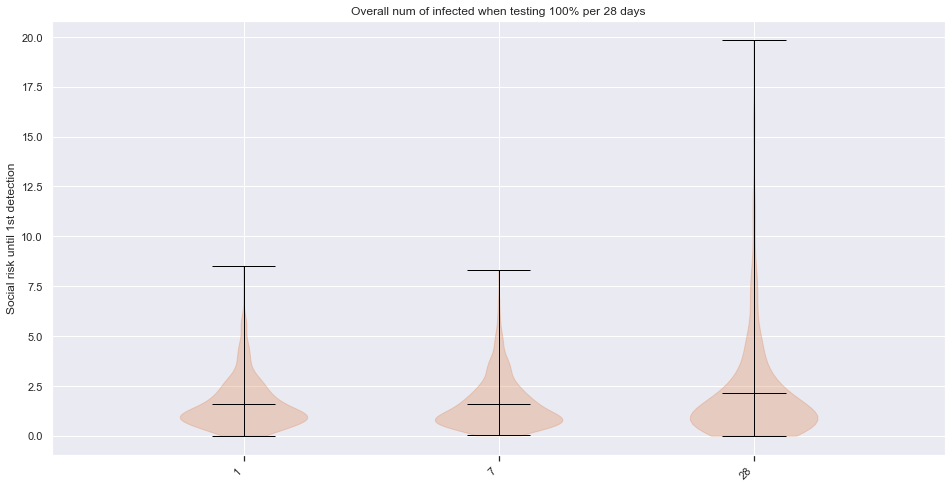

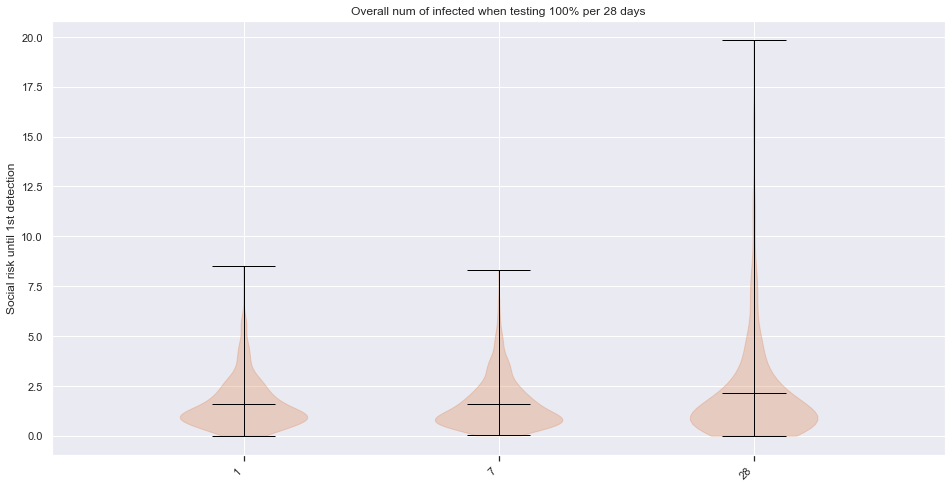

In [18]:
total = 28
show_violins(data[(data.total==total) & (data.R==2.8)],
             field = "numInfectious/average", 
             ylabel ="Social risk until 1st detection", 
             groupby="frequency", 
             title=f"Overall num of infected when testing 100% per {total} days")

In [19]:
def panels(data, yfield):
    daily = data[data.frequency==1]
    batch = data[data.frequency==data.total]
    panel1 = daily.groupby([yfield,"R"])["overallInfected/last"].mean().unstack()
    panel2 = batch.groupby([yfield,"R"])["overallInfected/last"].mean().unstack()
    panel3 = panel1/panel2*100
    return panel1,panel2,panel3

    

In [20]:
from matplotlib.colors import ListedColormap
def colormap(minval,midval,maxval, scale = "RdBu_r"):
    minval,midval,maxval = int(minval), int(midval), int(maxval)
    n = (maxval-minval)*10
    L = sns.color_palette(scale, n).as_hex()
    L1 = L[0:n//2:n//(2*(midval-minval))]
    L2 = L[n//2:n:n//(2*(maxval-midval))]
    return ListedColormap(L1+L2)
    
    
#greens = list(sns.color_palette("BuGn_d",(midval-minval)//2).as_hex())[::-1]
#L = greens + L1

#cmap_percentages = ListedColormap(L)
#L1 = sns.color_palette("RdBu_r", 2*MAX-10).as_hex()
#greens = list(reversed(sns.color_palette("BuGn_d",10).as_hex()))
#L = greens+L1[0:MAX:(MAX//10)] + L1[MAX:]
#from matplotlib.colors import ListedColormap
#cmap_numbers = ListedColormap(L)


In [29]:
from matplotlib.ticker import StrMethodFormatter 

def heatmap(data, yfield, ytitle, maxper = None, tight= False, maxval= 100):
    panel1,panel2,panel3 = panels(data,yfield)
    print(max(*panel1.values.flatten(),*panel2.values.flatten()))
    if maxval is None:
        maxval = max(*panel1.values.flatten(),*panel2.values.flatten())
    if not maxper:
        maxper = max(panel3.values.flatten())
    cmap_numbers = colormap(0,10,max(11,maxval))
    cmap_percentages = colormap(0,100,max(maxper,101), scale = 'RdYlGn_r')
    
    print(data.total.unique())
    

    size = 30
    titlesize = 40

    fig , axes = plt.subplots(1,3, sharex=True, sharey= True, figsize= (28,10))
    cbar_ax = fig.add_axes([-0.05, 0.15, .03, .7])
    #axes[0].title.set_text('28/4 vs baseline')
    #cmap = sns.diverging_palette(150, 275, sep=1,s=80, l=55, n=25)
    #fig.suptitle(f'Daily vs Batch testing - {statistic} overall infected individuals', fontsize=int(titlesize*1.1), color="blue")
    #fig.subplots_adjust(top=1)


    fmt = ".1f" 

    color = "white"
    axes[0].set_title("a) Cost with daily testing",loc="left",fontsize=int(titlesize))
    sns.heatmap(panel1,ax=axes[0],cbar=True, cbar_ax = cbar_ax ,  fmt=fmt, vmin=0,vmax= maxval, annot=False,cmap=cmap_numbers)# annot=True,fmt='.0f' ,cmap=cmap) # annot_kws={'color':color}

    axes[1].set_title('b) Cost with batch testing', loc='left',fontsize=int(titlesize))
    sns.heatmap(panel2,ax=axes[1],cbar=False, vmin=0,vmax= maxval, fmt=fmt,  annot= False,cmap=cmap_numbers)# annot=True,fmt='.0f', cmap=cmap)

    axes[2].set_title('c) Daily / Batch cost (%)', loc='left',fontsize=int(titlesize))
    sns.heatmap(panel3,ax=axes[2],cbar=True,  annot= False, fmt=fmt, vmin=0 ,vmax= max(100,maxper), cmap = cmap_percentages)# annot=True,fmt='.0f', cmap=cmap)
    #sns.heatmap(percent,ax=axes[2],vmin=0,vmax=125,cbar=True,  annot= True, fmt='.0f', cmap=cmap_percentages)# annot=True,fmt='.0f', cmap=cmap)

    cbar = axes[0].collections[0].colorbar
    cbar.ax.set_ylabel('# of individuals infected at detection',fontsize=size)
    cbar.ax.yaxis.set_ticks_position('left')
    cbar.ax.yaxis.set_label_position('left')
    cbar_ax.tick_params(axis='y',labelsize=size)
    cbar_ax = axes[2].collections[0].colorbar.ax
    #cbar_ax.set_ylabel('daily cost as % of batch cost',fontsize=20, rotation = 270)
    
    cbar_ax.text(4.5, 0.5, 'daily cost as % of batch cost', rotation=270, fontsize= size,
            verticalalignment='center', horizontalalignment='right', 
            transform=cbar_ax.transAxes)
    cbar_ax.tick_params(axis='y',labelsize=size)
    from fractions import Fraction

    def format_func(value, tick_number):
        introductions = sorted(data.average_introductions_per_day.unique())
        f = Fraction(introductions[tick_number]).limit_denominator(100)
        return fr"$\frac{{{f.numerator}}}{{{f.denominator}}}$"
    
    def format_func2(value,tick_number):
        budgets = sorted(data[yfield].unique())
        v = budgets[tick_number]
        return fr"$\frac{{1}}{{{v}}}$"
    
    


    for i in range(3):
        axes[i].set_ylabel('' if i else ytitle, fontsize=size)
        axes[i].set_xlabel('' if i!=1 else 'Reproductive number', fontsize=titlesize)
        axes[i].tick_params(axis='x', rotation=45, labelsize= size)
        axes[i].tick_params(axis='x', labelsize=size ) 
        axes[i].tick_params(axis='y',labelsize=size ) 


    if yfield == 'average_introductions_per_day':
        axes[0].yaxis.set_major_formatter(plt.FuncFormatter(format_func))
    else:
        axes[0].yaxis.set_major_formatter(plt.FuncFormatter(format_func2))
        axes[0].tick_params(axis='y',rotation=0 ) 
    axes[0].tick_params(axis='y',labelsize= titlesize) 

    #fig.text(0.15,0,'* Dropping runs where all infected individuals recovered before detection', fontsize=12)
    cbar = axes[2].collections[0].colorbar
    #cbar.set_yticklabels([f"{int(i)}%" for i in cbar.get_ticks()]) # set ticks of your format
    #plt.show()


    if tight: fig.tight_layout() #rect=[0, 0, .9, 1])

    return fig

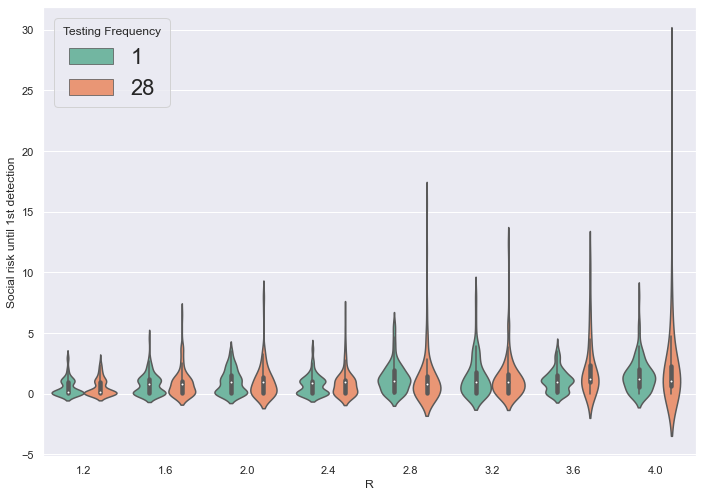

In [38]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax1 = sns.violinplot(x="R", 
                    y="numInfectious/average", 
                    hue="frequency",
                    data=data[(data.experiment=='varying_total') & (data.total==total)], 
                    palette="Set2", 
                    )
ax1.set(xlabel='R', ylabel='Social risk until 1st detection')
plt.legend(loc='upper left', title='Testing Frequency', fontsize='22')
plt.show()

58.63
[28]
<ipython-input-29-7c4a85adf3ef>:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  if tight: fig.tight_layout() #rect=[0, 0, .9, 1])


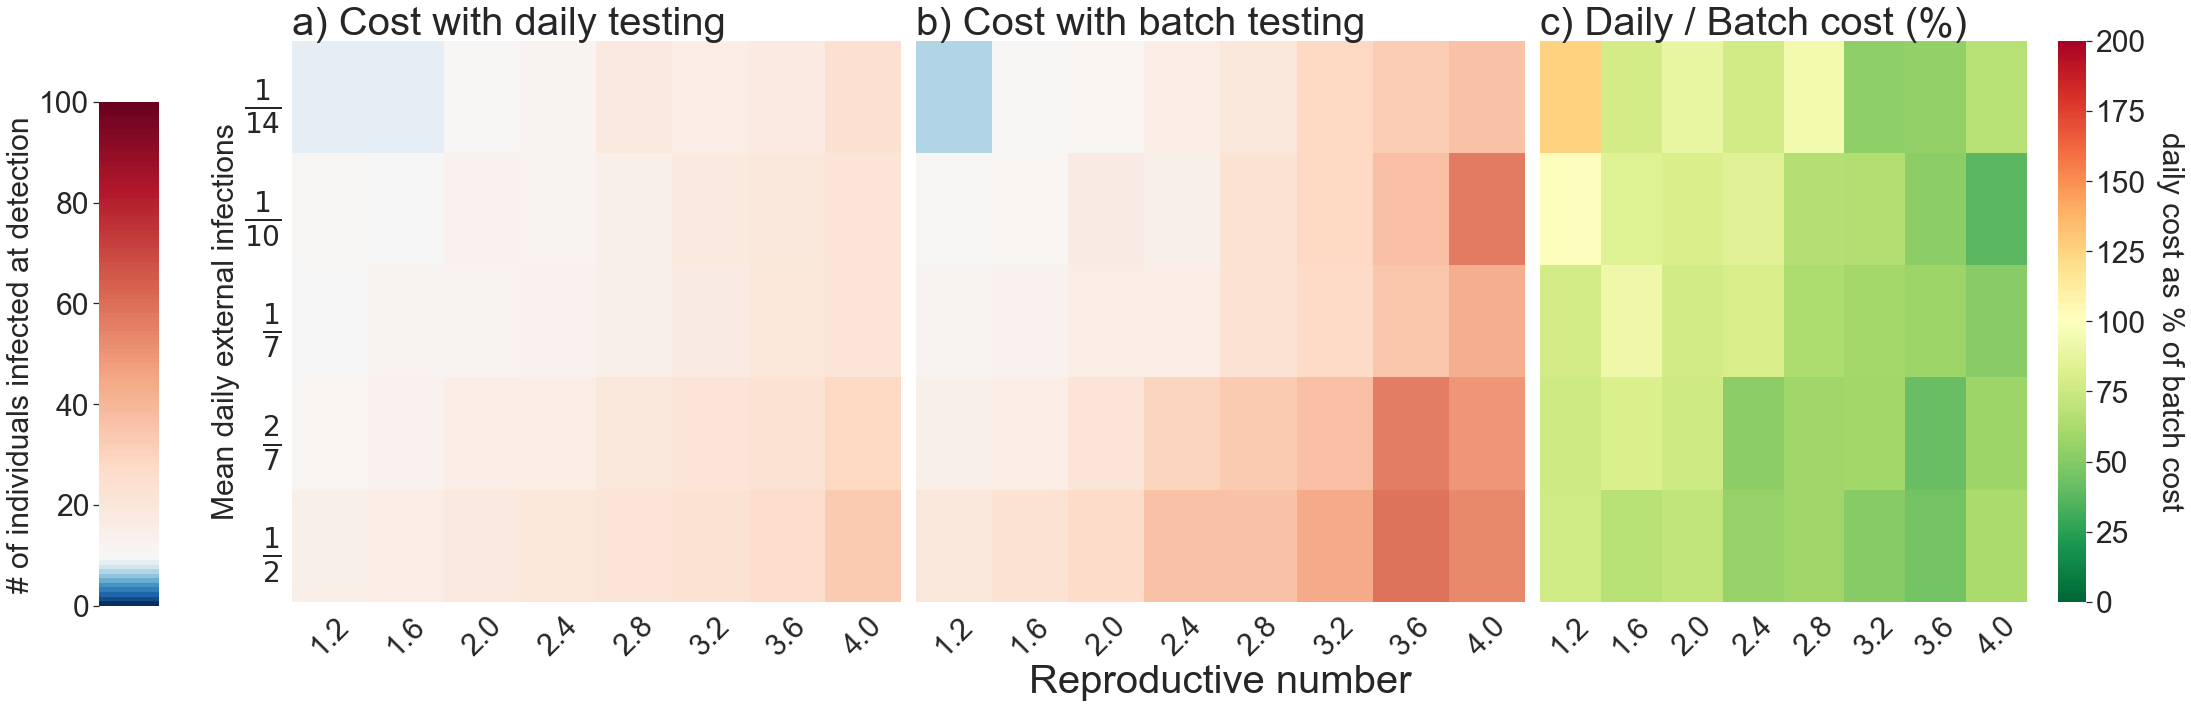

In [31]:
data = data[data.R < 4.1]
external_plot1 = heatmap(data[data.experiment=='external_introductions'],'average_introductions_per_day','Mean daily external infections', maxper =200, tight = True)
external_plot1.savefig('data/barabasi_albert/BA_external1.png')

75.67
[ 2  7 14 28 35 42]
<ipython-input-29-7c4a85adf3ef>:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  if tight: fig.tight_layout() #rect=[0, 0, .9, 1])


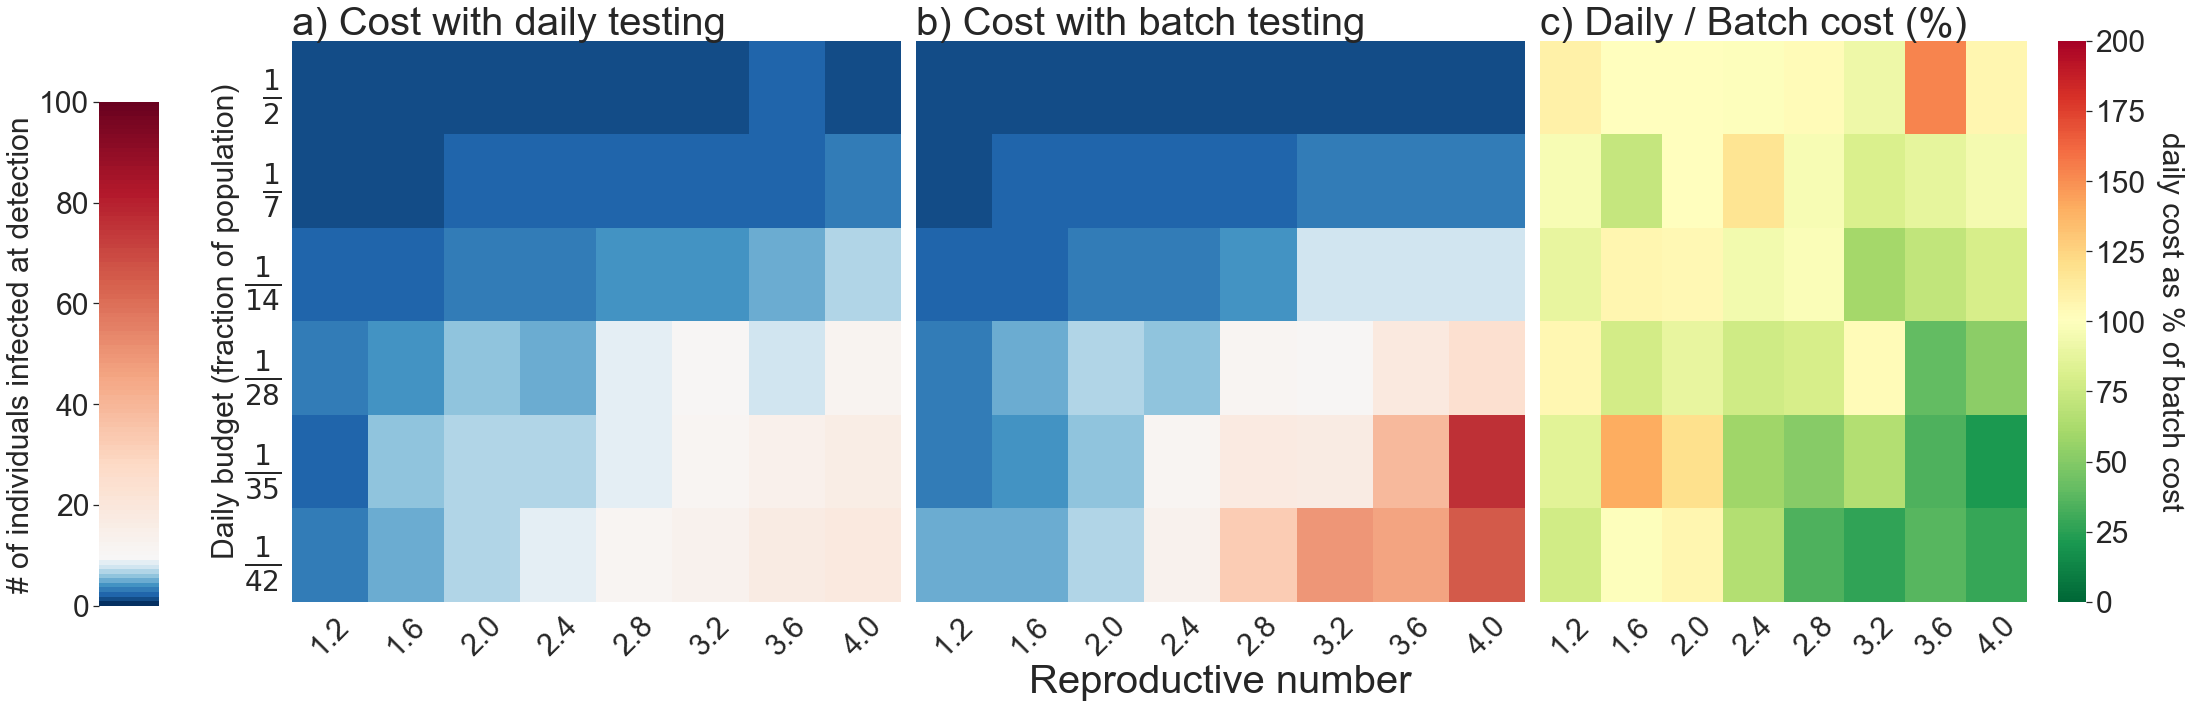

In [32]:
total_plot1 = heatmap(data[(data.experiment=='varying_total') & (data.total>1)],'total','Daily budget (fraction of population)', maxper = 200, tight=True)
total_plot1.savefig('data/barabasi_albert/BA_total1.png')

In [14]:
def cost_curves(df,FREQS, BUDGET=28, title = None, ylim=None, percentile=None):
    if title is None:
        title = f"Overall infection per policy for budget of testing 100% every {BUDGET} days"
    sns.set_style('ticks') 
    fontsmall = 14
    fontlarge = 18
    fig = plt.figure(figsize=(12, 6), dpi = 200)
    ax = fig.add_subplot(111)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    budget = df[df.total==BUDGET ] 
    Rs = sorted(budget.R.unique())
    colors = sns.color_palette("tab10", len(FREQS))
    i = 0
    for f in FREQS[::-1]: 
        temp = budget[budget.frequency==f].groupby('R')['overallInfected/last']
        if percentile is None:
            cost = [temp.mean().loc[R] for R in Rs]
            upper = [temp.quantile(0.95).loc[R] for R in Rs]
            lower = [temp.quantile(0.05).loc[R] for R in Rs]
            ax.plot(Rs,cost, color = colors[i], label = f"Test every {f} day{'s' if f>1 else ''} ({BUDGET//f} batch{'es' if f<BUDGET else ''})", zorder = 20-2*i)    
            ax.fill_between(Rs,lower,upper, color = colors[i], alpha = 0.2, zorder = 20-2*i-1)
        else:            
            cost = [temp.quantile(percentile).loc[R] for R in Rs]
            ax.plot(Rs,cost, color = colors[i], label = f"Test every {f} day{'s' if f>1 else ''} ({BUDGET//f} batch{'es' if f<BUDGET else ''})", zorder = 20-2*i)    
            # {percentile*100:.0f}th percentile
        i += 1    
    handles, labels = ax.get_legend_handles_labels()
    ax.set_xticks(Rs)
    l = ax.legend([handle for i,handle in enumerate(handles)],  [label for i,label in enumerate(labels)], loc = 'upper left', frameon=False, fontsize= fontsmall)
    l.set_zorder(50) 
    if percentile:
        title += f' ({percentile*100:.0f}th percentile)'
    #ax.set_title(title,fontsize=fontlarge)
    ax.set_xlabel("Reproductive number", fontsize= fontsmall)
    ax.set_ylabel("Overall number of infected individuals",fontsize= fontsmall)
    ax.tick_params(axis='y', labelsize=fontsmall )
    ax.tick_params(axis='x', labelsize=fontsmall )
    if ylim:
        ax.set_ylim(0,ylim)
    fig.show()
    #fig.text(0.15,0,'* Shaded area from 25th to 75th percentile. Dropping runs where all infected individuals recovered before detection', fontsize=8

<ipython-input-46-2116cfdcf97b>:41: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


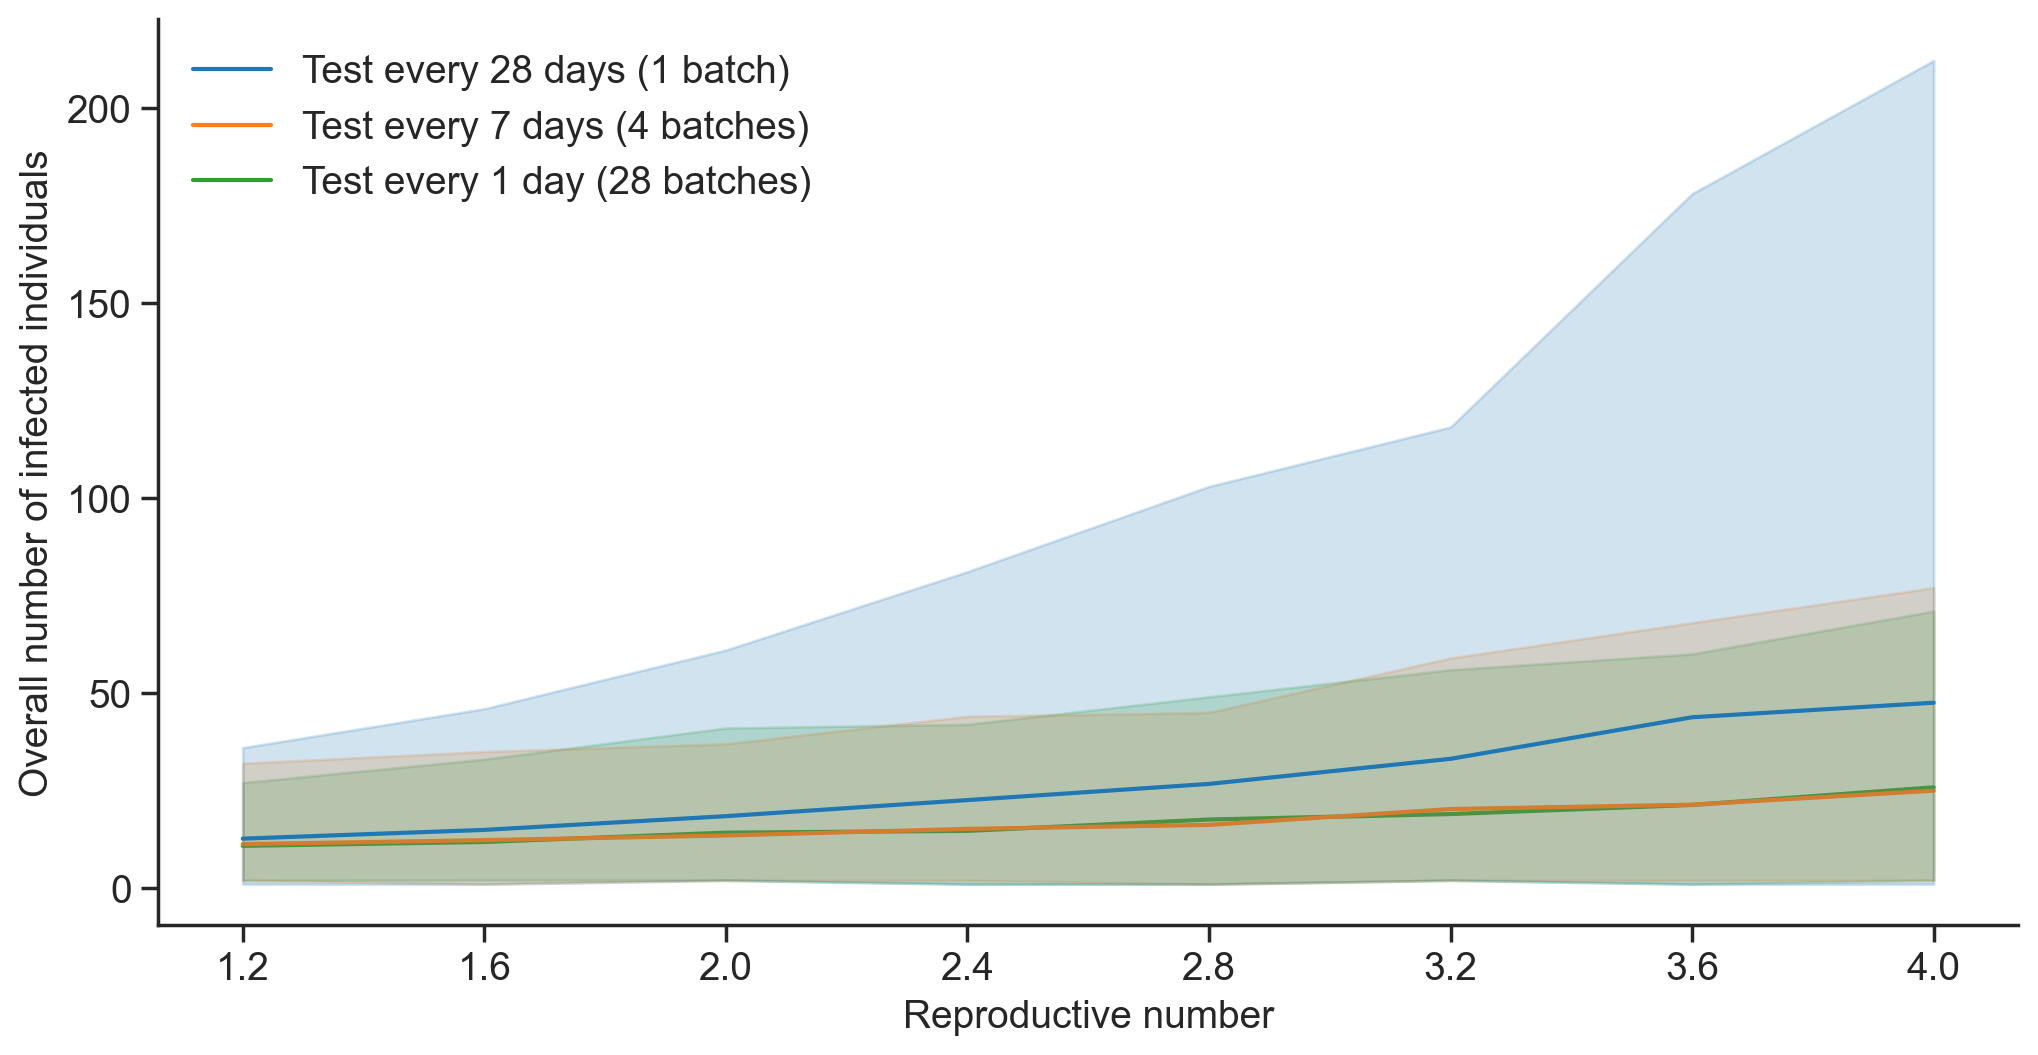

In [47]:
cost_curves(data[data.experiment=='external_introductions'], FREQS = [1, 7, 28])

In [9]:
# random partition

totals = [1,2,7,14,28,35,42]

Rs = [1.2, 1.6, 2, 2.4, 2.8,3.2,3.6,4.0,4.4,4.8]
torun2 = []
SKIP_PRE = True

INIT_INFECT = 1
INTRO_DAY = 0

# heat map budget

network = barabasi_albert(N=500, m=50)
for total in totals:
    for f in [1,total]: 
        for R in Rs: #numpy.linspace(1.0,4.0,15):
            N = network['N']
            D = {"N":N,
                 "frequency":f,
                 "experiment" : "varying_total",
                 "type": f"freq={f}/tot={total}/R={R}",
                 "R":R,
                 "total": total,
                 **network, 
                 **infect_params_orig(N,R,average_introductions_per_day = INTRO_DAY, single_intro_by=None, skip_pre=SKIP_PRE),
                 **run_params(N,frac_tested=f/total,frequency=f, testing_compliance_symptomatic=0),
                 "initE": INIT_INFECT,
                 "runTillEnd": INIT_INFECT>0,
                }
            torun2.append(D)


# external infection

for total in [28]:
    for rate in [1/14,1/10,1/7,1/3.5,1/2]:
        for f in [1,7,28]:# [1]+totals:
            if total % f: continue
            for R in Rs: #numpy.linspace(1.0,4.0,15):
                N = network['N']
                D = {"N":N,
                     "frequency":f,
                     "experiment" : "external_introductions",
                     "type": f"freq={f}/tot={total}/R={R}/ext={rate}",
                     "R":R,
                     "total": total,
                     **network, 
                     **infect_params_orig(N,R,average_introductions_per_day = rate, single_intro_by=None, skip_pre=SKIP_PRE),
                     **run_params(N,frac_tested=f/total,frequency=f, testing_compliance_symptomatic=0),
                     "initI_asym": 0,
                     "runTillEnd": True
                    }
                torun2.append(D)

realizations = 100

In [11]:
os.chdir(PATH)
print(os.getcwd())
if not os.path.exists("data/"):
    os.makedirs("data")

timestamp = datetime.now().strftime('%Y%m%d_%H_%M_%S')
#datadir = f"data/heatmap_{timestamp}_{realizations}"
datadir = f"data/barabasi_albert"
if not os.path.exists("data/barabasi_albert"):
    os.makedirs("data/barabasi_albert")

torun2_fname = datadir+"/torun2.pickle"
save_to_file(torun2,torun2_fname)

/Users/antares/Desktop/seirsplus


In [12]:
%%time
os.chdir("seirsplus")
!python3 -m seirsplus.parallel_run --torun "/Users/antares/Desktop/seirsplus/$torun2_fname" --realizations $realizations --savename "../$datadir/heatmap2_data"
os.chdir(PATH)

Arguments:
torun : /Users/antares/Desktop/seirsplus/data/barabasi_albert/torun2.pickle
realizations : 100
savename : ../data/barabasi_albert/heatmap2_data
Loading torun
Loaded
Preparing list to run
Starting execution of 29000 runs
100%|███████████████████████████████████| 29000/29000 [4:56:03<00:00,  1.63it/s]
done
Saving csv
Saving split parts
Saving pickle 1
Done
CPU times: user 7min 28s, sys: 2min 34s, total: 10min 2s
Wall time: 4h 56min 20s


In [36]:
data2 = read_from_file(datadir+"/heatmap2_data")
summarize(censor(restrict(data2,total=28,R=2.0)))

Loading chunk 1
Total: [28] R: [2.] min(numPositive/sum): 1.0
Frequency: risk(mean),risk(90%) | overall(mean),overall(90%)
01:        1.56, 2.95           | 14.43 , 33.0                   | count=557 
07:        1.51, 2.87           | 14.73 , 32.0                   | count=498 
28:        2.08, 4.86           | 21.16 , 52.0                   | count=556 


84.08
[28]
<ipython-input-29-7c4a85adf3ef>:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  if tight: fig.tight_layout() #rect=[0, 0, .9, 1])


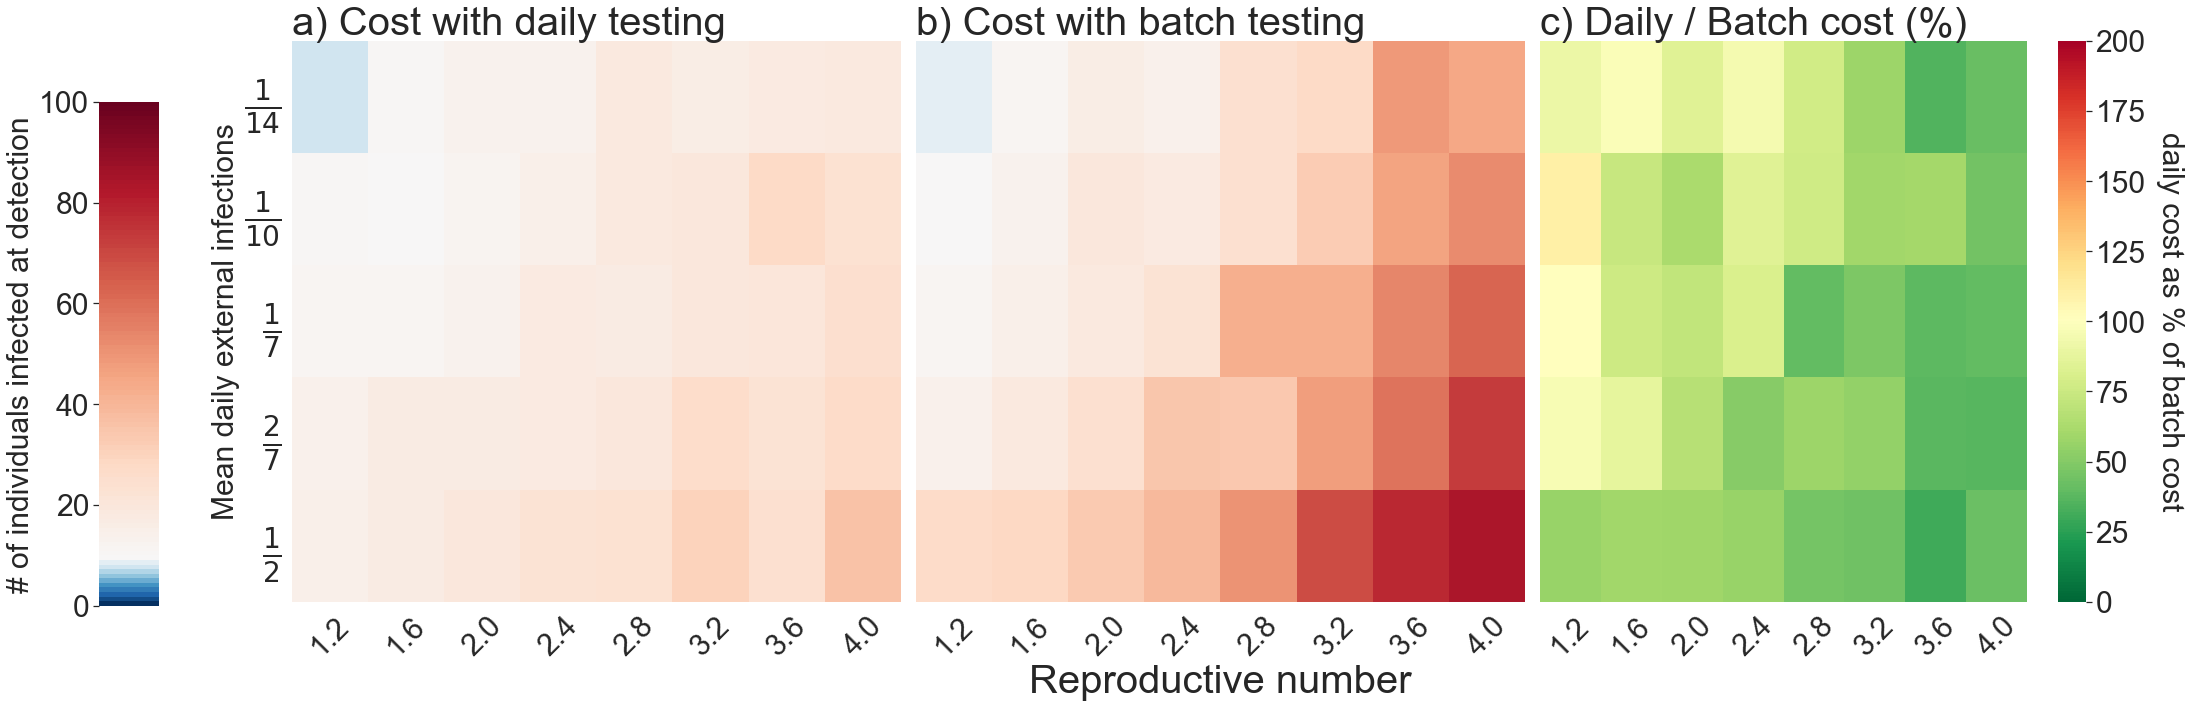

In [40]:
data2 = data2[data2.R < 4.1]
external_plot2 = heatmap(data2[data2.experiment=='external_introductions'],'average_introductions_per_day','Mean daily external infections', maxper =200, tight = True)
external_plot2.savefig('data/barabasi_albert/BA_external2.png')

92.28
[ 2  7 14 28 35 42]
<ipython-input-29-7c4a85adf3ef>:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  if tight: fig.tight_layout() #rect=[0, 0, .9, 1])


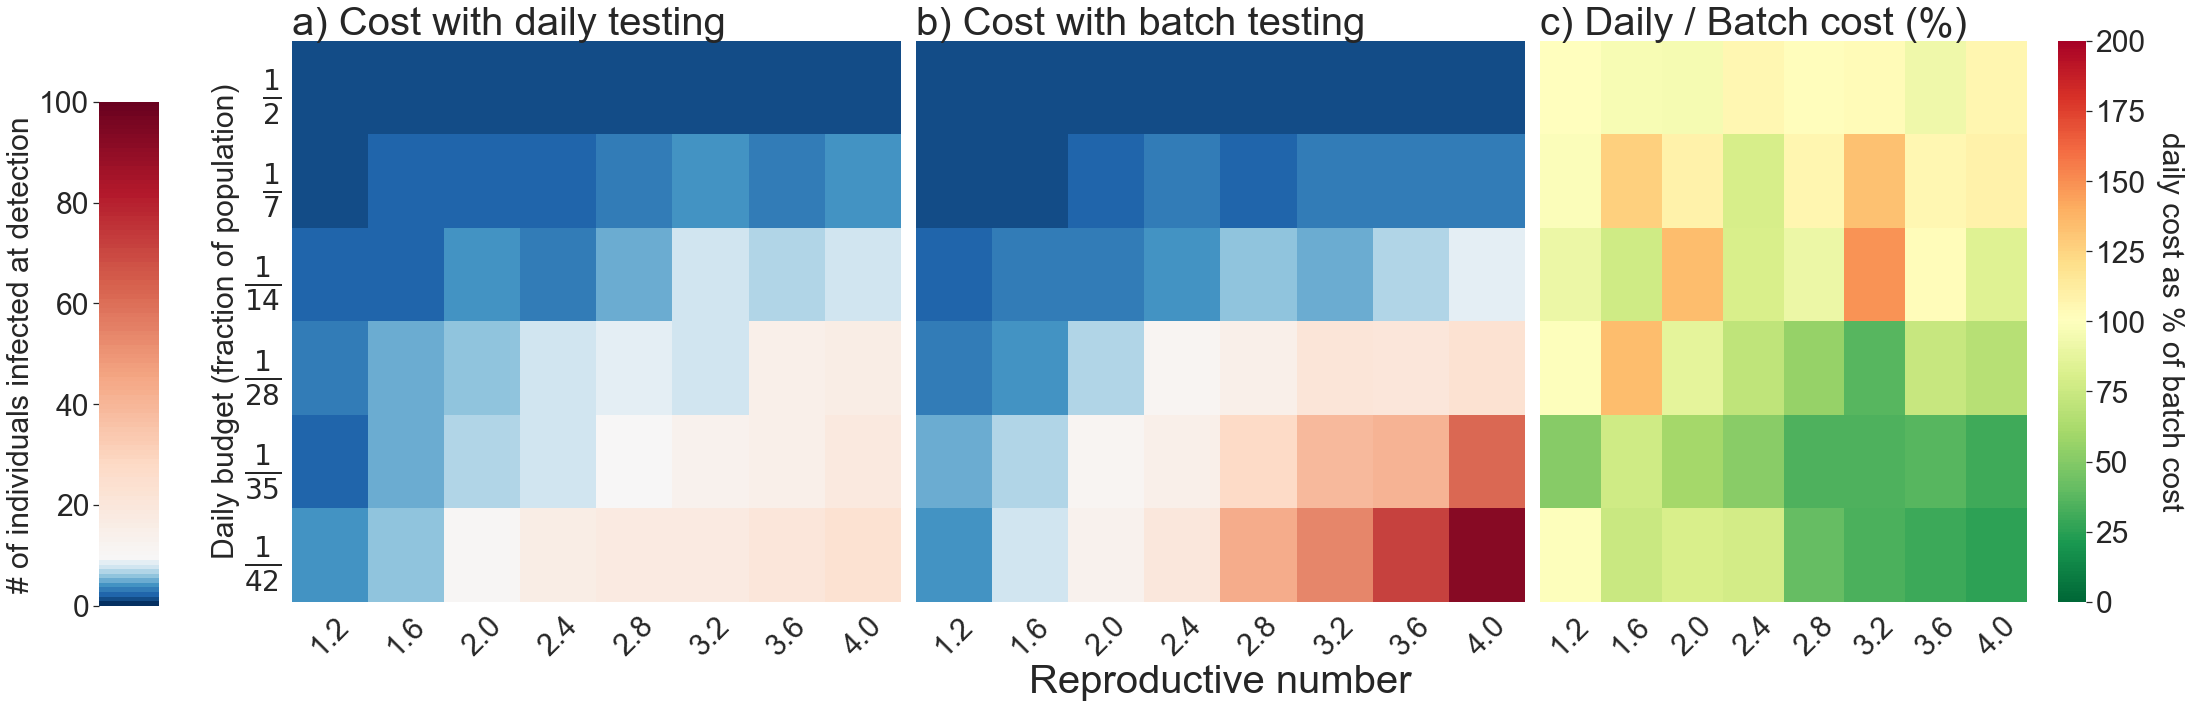

In [41]:
total_plot2 = heatmap(data2[(data2.experiment=='varying_total') & (data2.total>1)],'total','Daily budget (fraction of population)', maxper = 200, tight=True)
total_plot2.savefig('data/barabasi_albert/BA_total2.png')

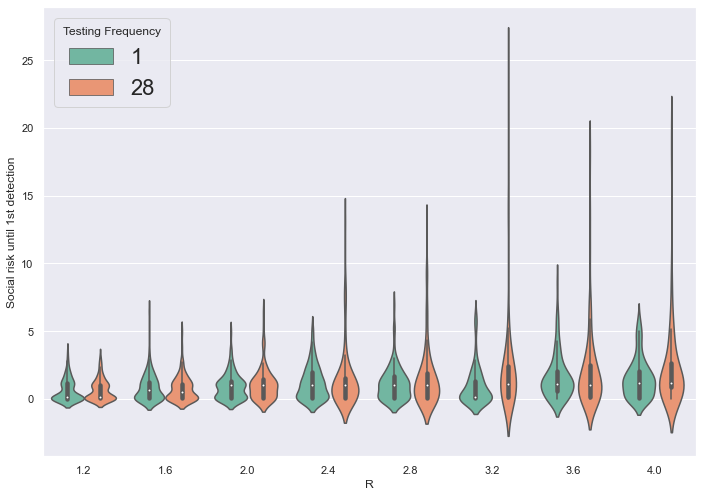

In [42]:
total = 28
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax1 = sns.violinplot(x="R", 
                    y="numInfectious/average", 
                    hue="frequency",
                    data=data2[(data2.experiment=='varying_total') & (data2.total==total)], 
                    palette="Set2", 
                    )
ax1.set(xlabel='R', ylabel='Social risk until 1st detection')
plt.legend(loc='upper left', title='Testing Frequency', fontsize='22')
plt.show()

<ipython-input-46-2116cfdcf97b>:41: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


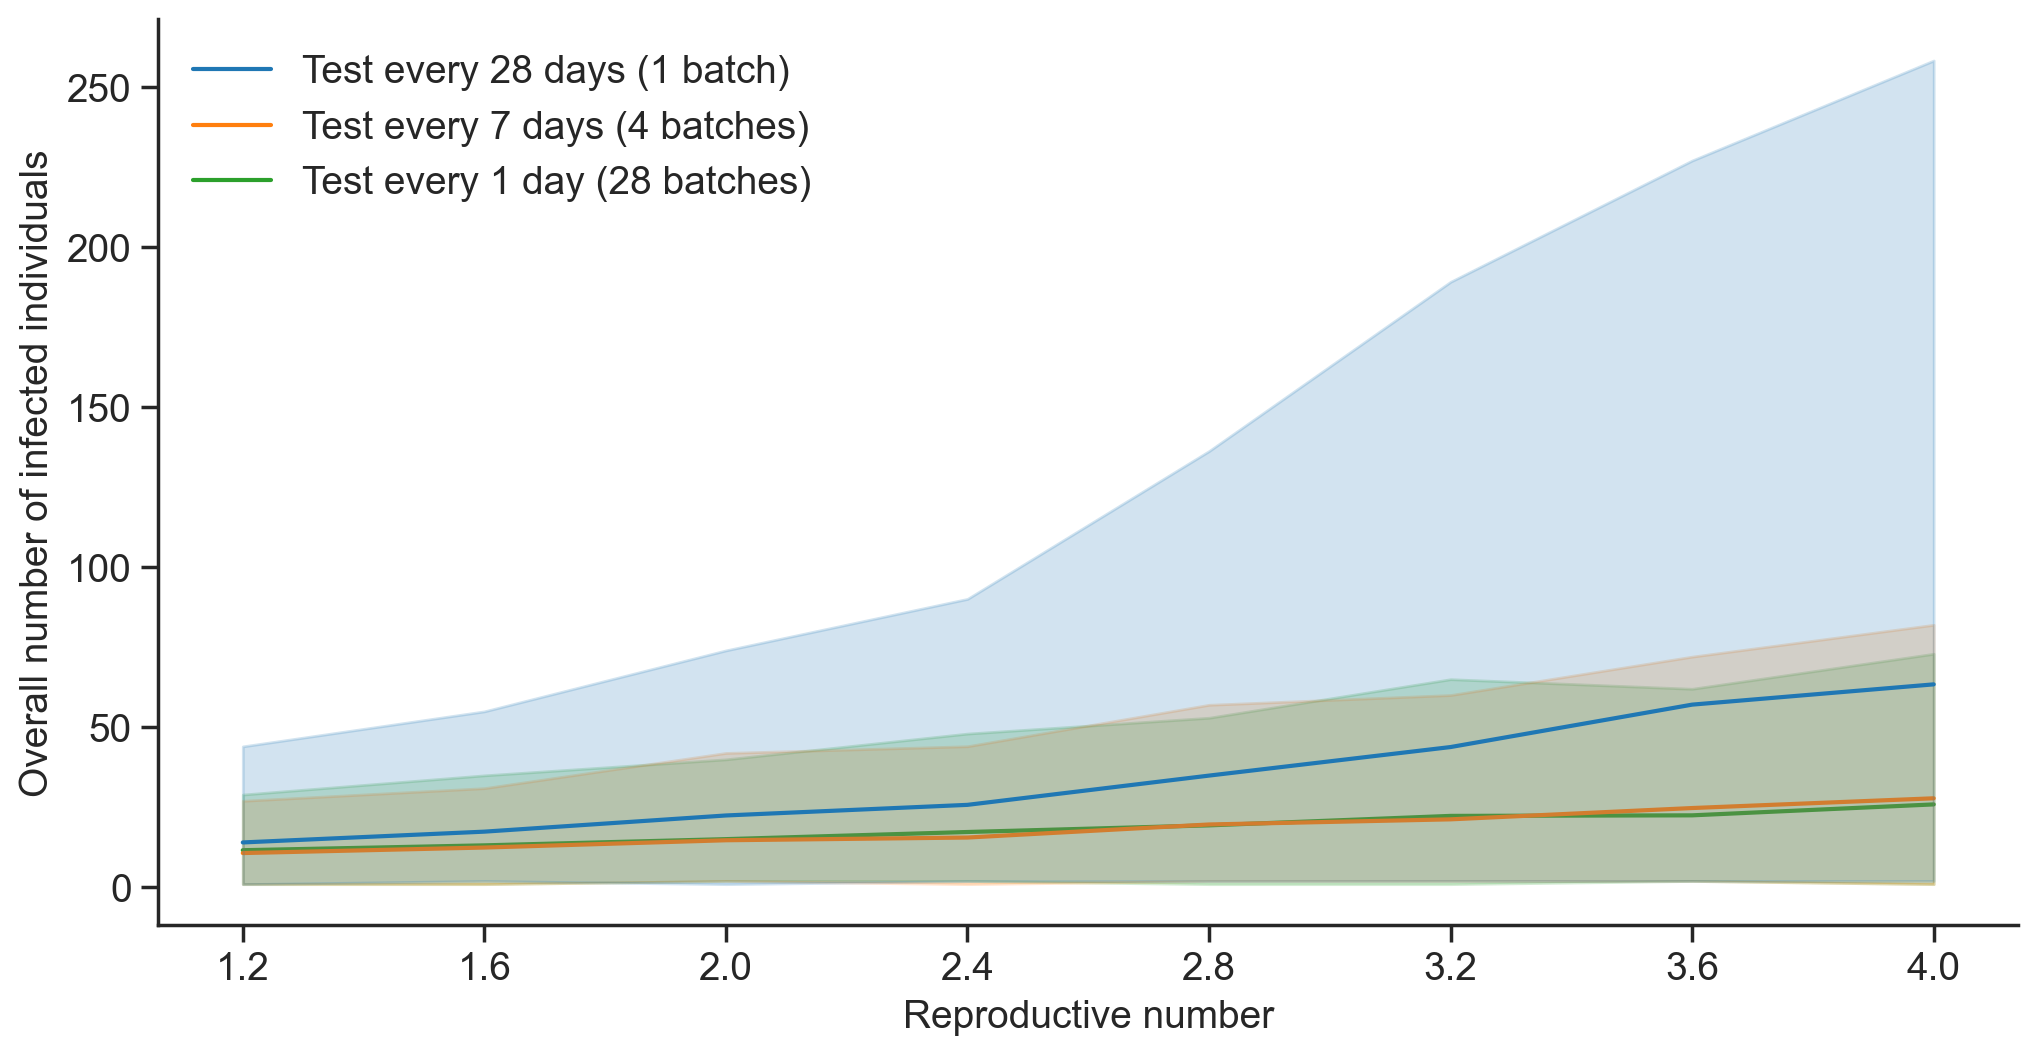

In [48]:
cost_curves(data2[data2.experiment=='external_introductions'], FREQS = [1, 7, 28])

In [9]:
# random partition

totals = [1,2,7,14,28,35,42]

Rs = [1.2, 1.6, 2, 2.4, 2.8,3.2,3.6,4.0,4.4,4.8]
torun3 = []
SKIP_PRE = True

INIT_INFECT = 1
INTRO_DAY = 0

# heat map budget

network = barabasi_albert(N=500, m=100)
for total in totals:
    for f in [1,total]: 
        for R in Rs: #numpy.linspace(1.0,4.0,15):
            N = network['N']
            D = {"N":N,
                 "frequency":f,
                 "experiment" : "varying_total",
                 "type": f"freq={f}/tot={total}/R={R}",
                 "R":R,
                 "total": total,
                 **network, 
                 **infect_params_orig(N,R,average_introductions_per_day = INTRO_DAY, single_intro_by=None, skip_pre=SKIP_PRE),
                 **run_params(N,frac_tested=f/total,frequency=f, testing_compliance_symptomatic=0),
                 "initE": INIT_INFECT,
                 "runTillEnd": INIT_INFECT>0,
                }
            torun3.append(D)


# external infection

for total in [28]:
    for rate in [1/14,1/10,1/7,1/3.5,1/2]:
        for f in [1,7,28]:# [1]+totals:
            if total % f: continue
            for R in Rs: #numpy.linspace(1.0,4.0,15):
                N = network['N']
                D = {"N":N,
                     "frequency":f,
                     "experiment" : "external_introductions",
                     "type": f"freq={f}/tot={total}/R={R}/ext={rate}",
                     "R":R,
                     "total": total,
                     **network, 
                     **infect_params_orig(N,R,average_introductions_per_day = rate, single_intro_by=None, skip_pre=SKIP_PRE),
                     **run_params(N,frac_tested=f/total,frequency=f, testing_compliance_symptomatic=0),
                     "initI_asym": 0,
                     "runTillEnd": True
                    }
                torun3.append(D)

realizations = 10

In [10]:
os.chdir(PATH)
print(os.getcwd())
if not os.path.exists("data/"):
    os.makedirs("data")

datadir = f"data/barabasi_albert"
if not os.path.exists("data/barabasi_albert"):
    os.makedirs("data/barabasi_albert")

torun3_fname = datadir+"/torun3.pickle"
save_to_file(torun3,torun3_fname)

/Users/antares/Desktop/seirsplus


In [11]:
%%time
os.chdir("seirsplus")
!python3 -m seirsplus.parallel_run --torun "/Users/antares/Desktop/seirsplus/$torun3_fname" --realizations $realizations --savename "../$datadir/heatmap3_data"
os.chdir(PATH)

Arguments:
torun : /Users/antares/Desktop/seirsplus/data/barabasi_albert/torun3.pickle
realizations : 10
savename : ../data/barabasi_albert/heatmap3_data
Loading torun
Loaded
Preparing list to run
Starting execution of 2900 runs
100%|███████████████████████████████████████| 2900/2900 [28:48<00:00,  1.68it/s]
done
Saving csv
Saving split parts
Saving pickle 1
Done
CPU times: user 39.6 s, sys: 13.7 s, total: 53.3 s
Wall time: 28min 51s


Loading chunk 1
<ipython-input-14-2116cfdcf97b>:41: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


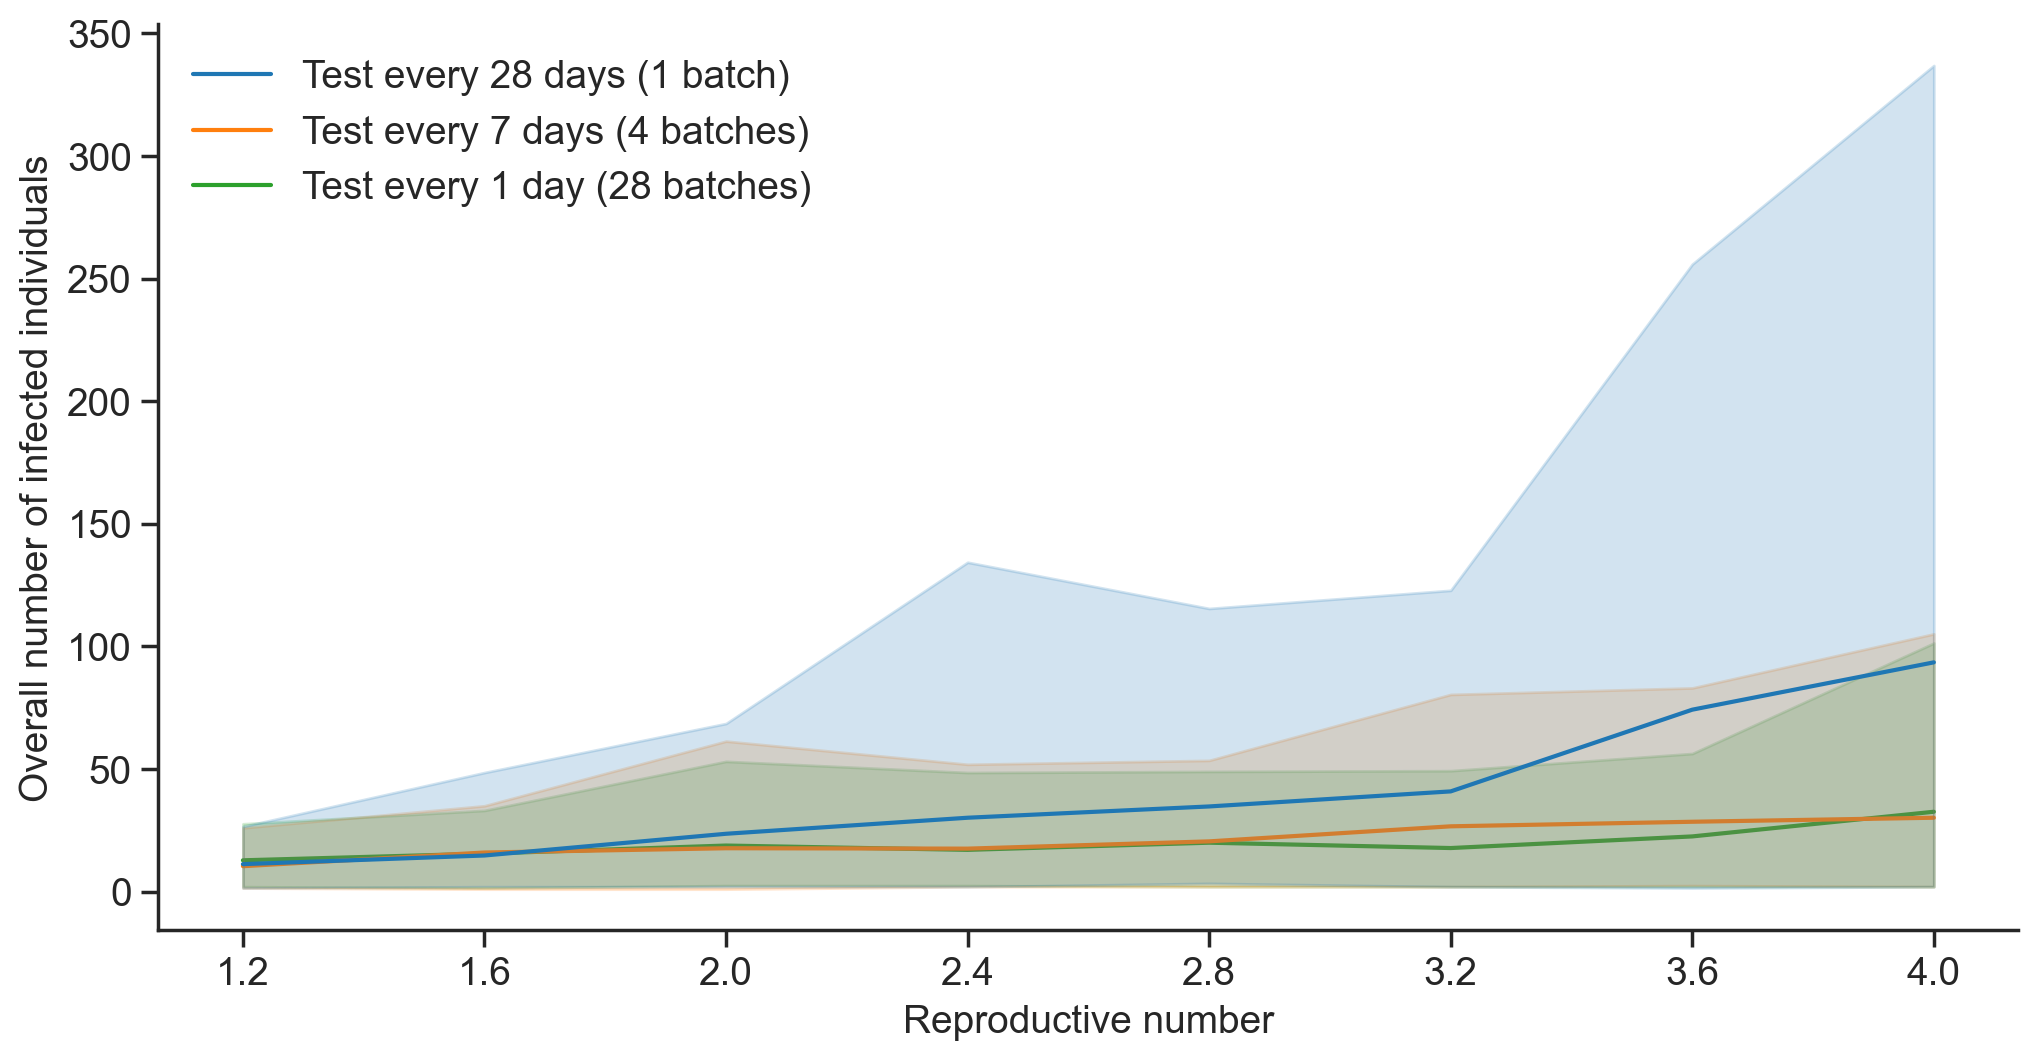

In [17]:
data3 = read_from_file(datadir+"/heatmap3_data")
data3 = data3[data3.R < 4.1]
cost_curves(data3[data3.experiment=='external_introductions'], FREQS = [1, 7, 28])